# Store-Sales Forecasting!

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from prophet import Prophet
from scipy import stats
import scipy.signal as signal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import xgboost as xgb


#### The Datasets

##### Train
##### store
##### oil
##### Transactions
##### Holidays
##### Test

In [3]:
train_df = pd.read_csv('train.csv')

In [4]:
store_df = pd.read_csv('stores.csv')

In [5]:
oil_df = pd.read_csv('oil.csv')

In [6]:
trans_df = pd.read_csv('transactions.csv')

In [7]:
holly_df = pd.read_csv('holidays_events.csv')

In [8]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

##### Data Cleaning and Exploration

In [9]:
train_df.corr()

,id,store_nbr,sales,onpromotion
id,1.000000,0.000301,0.085784,0.206260
store_nbr,0.000301,1.000000,0.041196,0.007286
sales,0.085784,0.041196,1.000000,0.427923
onpromotion,0.206260,0.007286,0.427923,1.000000


In [10]:
store_df.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [11]:
store_df.corr()

,store_nbr,cluster
store_nbr,1.000000,-0.059284
cluster,-0.059284,1.000000


In [12]:
oil_df.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [13]:
oil_df.shape

(1218, 2)

In [14]:
oil_df = oil_df.interpolate(method='linear', limit_direction='both')

In [15]:
trans_df.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [16]:
trans_df.corr()

,store_nbr,transactions
store_nbr,1.000000,0.189311
transactions,0.189311,1.000000


In [17]:
holly_df.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [18]:
train_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [19]:
trans_df.columns

Index(['date', 'store_nbr', 'transactions'], dtype='object')

In [20]:
holly_df.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [21]:
store_df.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

In [22]:
oil_df.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [23]:
# Merge train_df with trans_df on 'date' and 'store_nbr'
merged_df = train_df.merge(trans_df, on=['date', 'store_nbr'], how='left')

# Merge merged_df with holly_df on 'date'
merged_df = merged_df.merge(holly_df, on='date', how='left')

# Merge merged_df with store_df on 'store_nbr'
merged_df = merged_df.merge(store_df, on='store_nbr', how='left')

# Merge merged_df with oil_df on 'date'
df = merged_df.merge(oil_df, on='date', how='left')

In [24]:
# Display the columns of the merged dataset
print(df.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'type_x', 'locale', 'locale_name', 'description',
       'transferred', 'city', 'state', 'type_y', 'cluster', 'dcoilwtico'],
      dtype='object')


In [25]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,93.14


In [26]:
df.shape

(3054348, 17)

In [27]:
df.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
type_x          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
city                  0
state                 0
type_y                0
cluster               0
dcoilwtico       878526
dtype: int64

In [28]:
df.dtypes

id                int64
date             object
store_nbr         int64
family           object
sales           float64
onpromotion       int64
transactions    float64
type_x           object
locale           object
locale_name      object
description      object
transferred      object
city             object
state            object
type_y           object
cluster           int64
dcoilwtico      float64
dtype: object

In [29]:
# Select only the numeric columns from your DataFrame
#numeric_cols = df.select_dtypes(include=['number'])

# Initialize and fit the MinMaxScaler
#min_max_scaler = MinMaxScaler()
#scaled_data = min_max_scaler.fit_transform(numeric_cols)

# Initialize and fit the StandardScaler
#standard_scaler = StandardScaler()
#normalized_data = standard_scaler.fit_transform(numeric_cols)

In [30]:
# Apply a Butterworth filter to the numeric columns
#fs = 100  # sample rate
#nyquist = fs / 2
#cutoff_freq = 5  # cutoff frequency
#b, a = signal.butter(2, cutoff_freq / nyquist, 'lowpass')

#numeric_cols = df.select_dtypes(include=[np.number]).columns

#for col in numeric_cols:
#    df[col] = signal.filtfilt(b, a, df[col], padlen=1)

In [31]:
#df = df.interpolate(method='linear', limit_direction='both')
df = df.interpolate(method='ffill')
  # filled based on neighboring data points

In [32]:
df['date'] = pd.to_datetime(df['date'])

In [33]:
df.isna().sum()

id                0
date              0
store_nbr         0
family            0
sales             0
onpromotion       0
transactions    561
type_x            0
locale            0
locale_name       0
description       0
transferred       0
city              0
state             0
type_y            0
cluster           0
dcoilwtico        0
dtype: int64

In [34]:
df = df.dropna(subset=['transactions'])

In [35]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,dcoilwtico
561,561,2013-01-01,25,AUTOMOTIVE,0.0,0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,Salinas,Santa Elena,D,1,93.14
562,562,2013-01-01,25,BABY CARE,0.0,0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,Salinas,Santa Elena,D,1,93.14
563,563,2013-01-01,25,BEAUTY,2.0,0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,Salinas,Santa Elena,D,1,93.14
564,564,2013-01-01,25,BEVERAGES,810.0,0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,Salinas,Santa Elena,D,1,93.14
565,565,2013-01-01,25,BOOKS,0.0,0,770.0,Holiday,National,Ecuador,Primer dia del ano,False,Salinas,Santa Elena,D,1,93.14


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053787 entries, 561 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   transactions  float64       
 7   type_x        object        
 8   locale        object        
 9   locale_name   object        
 10  description   object        
 11  transferred   bool          
 12  city          object        
 13  state         object        
 14  type_y        object        
 15  cluster       int64         
 16  dcoilwtico    float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(4), object(8)
memory usage: 399.0+ MB


In [37]:
df.describe()

,id,store_nbr,sales,onpromotion,transactions,cluster,dcoilwtico
count,3.053787e+06,3.053787e+06,3.053787e+06,3.053787e+06,3.053787e+06,3.053787e+06,3.053787e+06
mean,1.504553e+06,2.750226e+01,3.590868e+02,2.617961e+00,1.689590e+03,8.481159e+00,6.784566e+01
std,8.661007e+05,1.558608e+01,1.107377e+03,1.225601e+01,9.383528e+02,4.649661e+00,2.566581e+01
min,5.610000e+02,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00,2.619000e+01
25%,7.550975e+05,1.400000e+01,0.000000e+00,0.000000e+00,1.055000e+03,4.000000e+00,4.632000e+01
50%,1.507852e+06,2.800000e+01,1.100000e+01,0.000000e+00,1.419000e+03,8.000000e+00,5.338000e+01
75%,2.255260e+06,4.100000e+01,1.962165e+02,0.000000e+00,2.035000e+03,1.300000e+01,9.572000e+01
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,8.359000e+03,1.700000e+01,1.106200e+02


In [38]:
df.corr()

,id,store_nbr,sales,onpromotion,transactions,transferred,cluster,dcoilwtico
id,1.000000,0.000049,0.086023,0.206022,-0.017518,0.097305,0.000077,-0.839231
store_nbr,0.000049,1.000000,0.041230,0.007714,0.169067,-0.000017,-0.059205,0.000143
sales,0.086023,0.041230,1.000000,0.428234,0.213019,-0.000424,0.038564,-0.075405
onpromotion,0.206022,0.007714,0.428234,1.000000,0.027058,0.020779,0.005717,-0.154720
transactions,-0.017518,0.169067,0.213019,0.027058,1.000000,-0.018120,0.195544,0.014281
transferred,0.097305,-0.000017,-0.000424,0.020779,-0.018120,1.000000,0.000008,-0.076807
cluster,0.000077,-0.059205,0.038564,0.005717,0.195544,0.000008,1.000000,-0.000068
dcoilwtico,-0.839231,0.000143,-0.075405,-0.154720,0.014281,-0.076807,-0.000068,1.000000


In [39]:
###### Based on correlation, Sales and promotion 

#### Visualizations

In [40]:
# Group the data by product family and calculate total sales for each family
product_family_sales = df.groupby('family')['sales'].sum().reset_index()

# Sort the data in descending order based on total sales
product_family_sales = product_family_sales.sort_values(by='sales', ascending=False)

# Display the top-selling product families
top_selling_families = product_family_sales.head(10)  # You can adjust the number as needed
print("Top Selling Product Families:")
print(top_selling_families)

Top Selling Product Families:
           family         sales
12      GROCERY I  3.508273e+08
3       BEVERAGES  2.216635e+08
30        PRODUCE  1.254480e+08
7        CLEANING  9.942102e+07
8           DAIRY  6.582360e+07
5    BREAD/BAKERY  4.295992e+07
28        POULTRY  3.249445e+07
24          MEATS  3.165100e+07
25  PERSONAL CARE  2.510048e+07
9            DELI  2.458563e+07


In [41]:
# Filter the data for rows where 'onpromotion' is True
promoted_data = df[df['onpromotion'] == 1]

# Group the data by 'family' and sum the 'sales' for each family
family_sales = promoted_data.groupby('family')['sales'].sum().reset_index()

# Sort the data by sales in descending order to find the top 5 promoted families
top_5_promoted_families = family_sales.sort_values(by='sales', ascending=False).head(5)

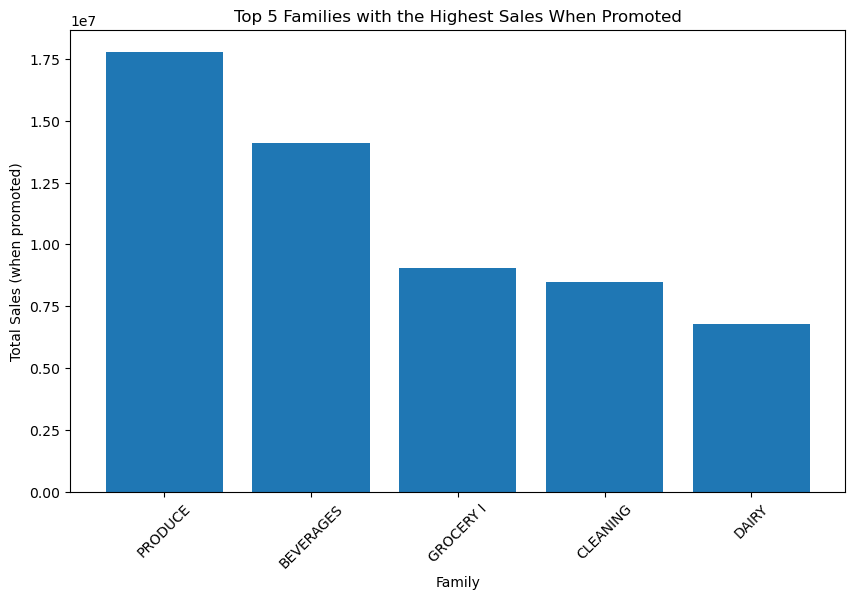

In [42]:
# Plot the bar chart for top five family products
plt.figure(figsize=(10, 6))
plt.bar(top_5_promoted_families['family'], top_5_promoted_families['sales'])
plt.xlabel('Family')
plt.ylabel('Total Sales (when promoted)')
plt.title('Top 5 Families with the Highest Sales When Promoted')
plt.xticks(rotation=45)  
plt.show()

In [43]:
# Group the data by 'cluster' and sum the 'sales' for each cluster
cluster_sales = df.groupby('cluster')['sales'].sum().reset_index()

# Sort the data by sales in descending order to find the cluster with the most sales
cluster_sales = cluster_sales.sort_values(by='sales', ascending=False)

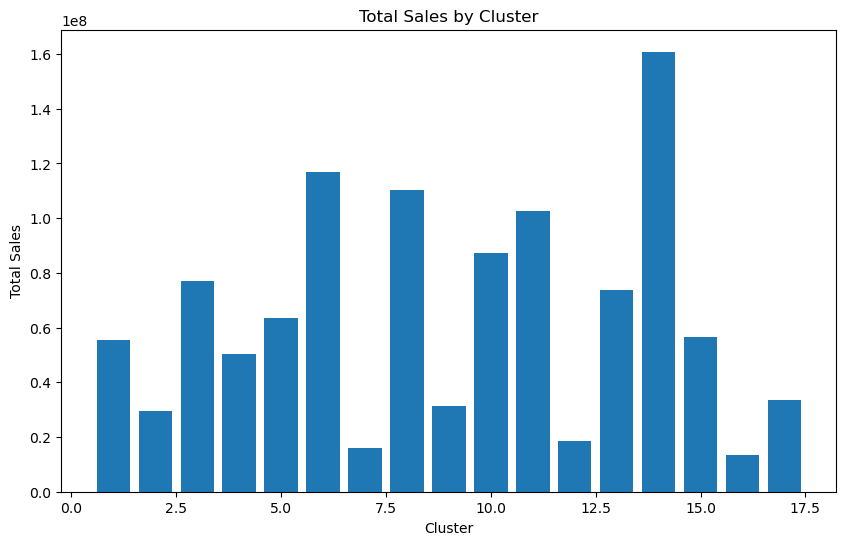

In [44]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(cluster_sales['cluster'], cluster_sales['sales'])
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.title('Total Sales by Cluster')
plt.xticks(rotation=0) 
plt.show()

In [45]:
# store stats
store_type_sales = df.groupby('type_x')['sales'].agg(['sum', 'mean', 'median', 'min', 'max', 'count'])

In [46]:
# distribution of sales across different store types
print("Distribution of Sales Across Different Store Types:")
print(store_type_sales)

Distribution of Sales Across Different Store Types:
                     sum        mean  median  min         max    count
type_x                                                                
Additional  5.450187e+07  477.885351    20.0  0.0   31851.158   114048
Bridge      7.054065e+06  359.864536     8.0  0.0   21367.000    19602
Event       8.933258e+07  394.728484    13.0  0.0  124717.000   226314
Holiday     7.796802e+08  347.609518    10.0  0.0   89576.360  2242977
Transfer    1.237044e+08  420.720465    19.0  0.0   28998.662   294030
Work Day    4.230164e+07  269.753328     3.0  0.0   21462.000   156816


In [47]:
# Group the data by year and calculate the total sales for each year
yearly_sales = df.groupby(df['date'].dt.year)['sales'].sum()

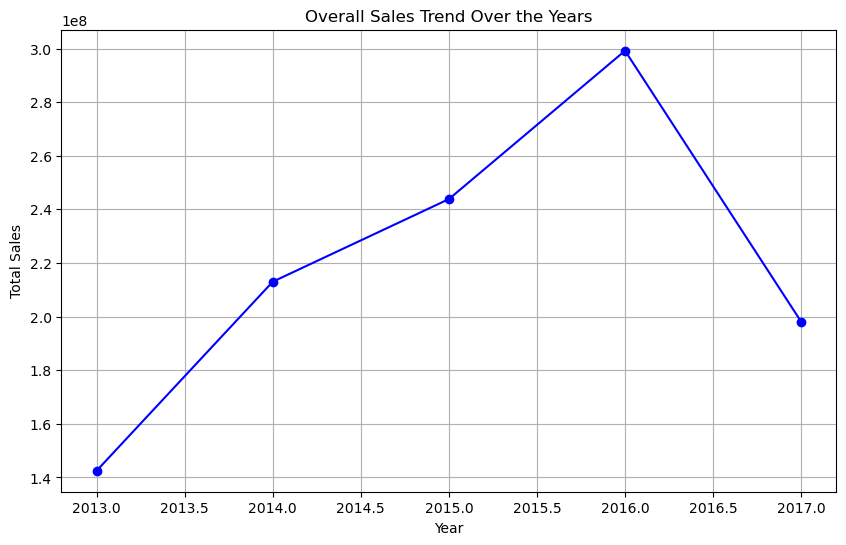

In [48]:
# checking for trends

plt.figure(figsize=(10, 6))  
plt.plot(yearly_sales.index, yearly_sales.values, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Overall Sales Trend Over the Years')
plt.grid(True)
plt.show()

In [49]:
df.cluster.unique()

array([ 1, 10,  8,  3,  6,  2,  4,  9,  5, 11, 14, 17, 13, 15,  7, 12, 16],
      dtype=int64)

In [50]:
# Group the data by cluster and calculate total sales for each cluster
cluster_sales = df.groupby('cluster')['sales'].sum()

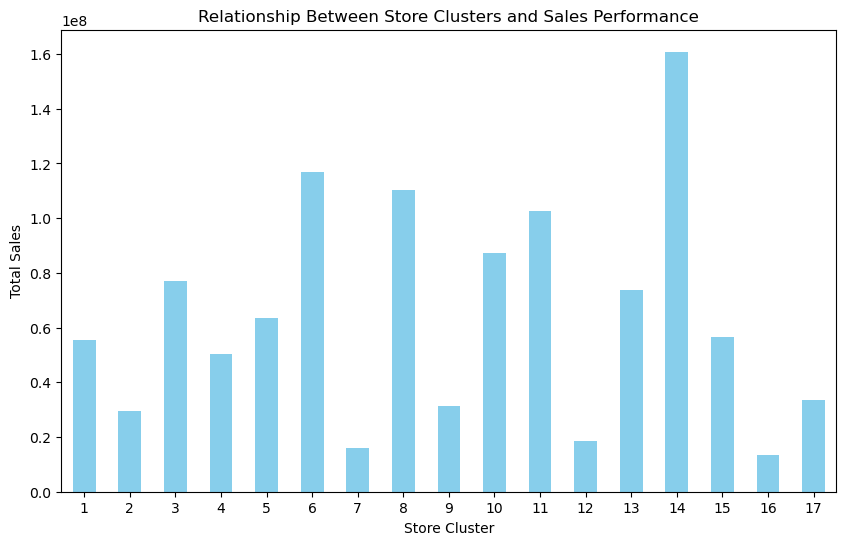

In [51]:
# Create a bar plot to visualize the relationship between store clusters and sales performance
plt.figure(figsize=(10, 6))  # Set the figure size
cluster_sales.plot(kind='bar', color='skyblue')
plt.xlabel('Store Cluster')
plt.ylabel('Total Sales')
plt.title('Relationship Between Store Clusters and Sales Performance')
plt.xticks(rotation=0)
plt.show()

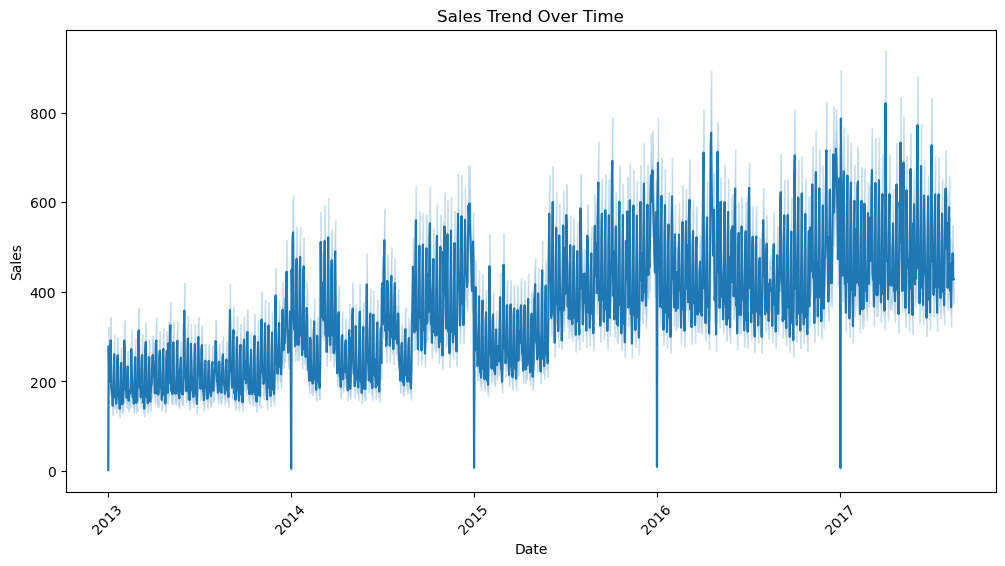

In [52]:
# Visualize sales trends over time


plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', data=df)
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

In [53]:
# Group the data by store_nbr and calculate the total sales for each store
store_sales = df.groupby('store_nbr')['sales'].sum().reset_index()

# Find the store with the highest sales
store_with_highest_sales = store_sales.loc[store_sales['sales'].idxmax()]

# Display the store number and its total sales
print(f"Store with the highest sales: Store {store_with_highest_sales['store_nbr']}")
print(f"Total Sales: {store_with_highest_sales['sales']}")

Store with the highest sales: Store 44.0
Total Sales: 63356137.229999


In [54]:
# Convert the 'date' column to numerical features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

In [55]:
df['day_of_week'] = df['date'].dt.dayofweek
df['weekend'] = (df['day_of_week'] >= 5).astype(int)

<AxesSubplot:xlabel='day_of_week'>

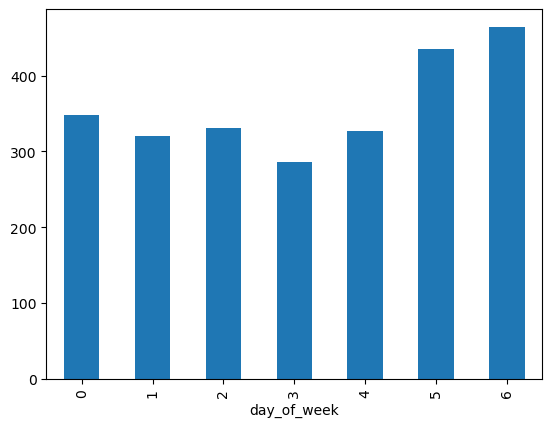

In [56]:
df.groupby('day_of_week')['sales'].mean().plot.bar()

<AxesSubplot:xlabel='weekend'>

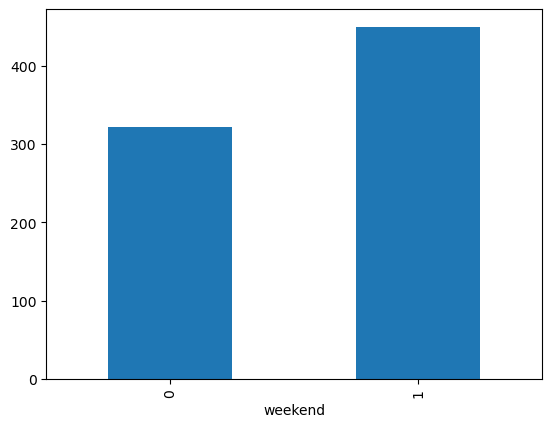

In [57]:
df.groupby('weekend')['sales'].mean().plot.bar()

In [58]:
# Group the data by month and calculate the mean sales for each month
monthly_sales = df.groupby(df['date'].dt.to_period('M'))['sales'].mean()
# Convert the PeriodIndex to DatetimeIndex
monthly_sales.index = monthly_sales.index.to_timestamp()

In [59]:
# Calculate a simple moving average for a smoother trend
window = 12  # 12 for the months in a year
rolling_mean = monthly_sales.rolling(window=window).mean()

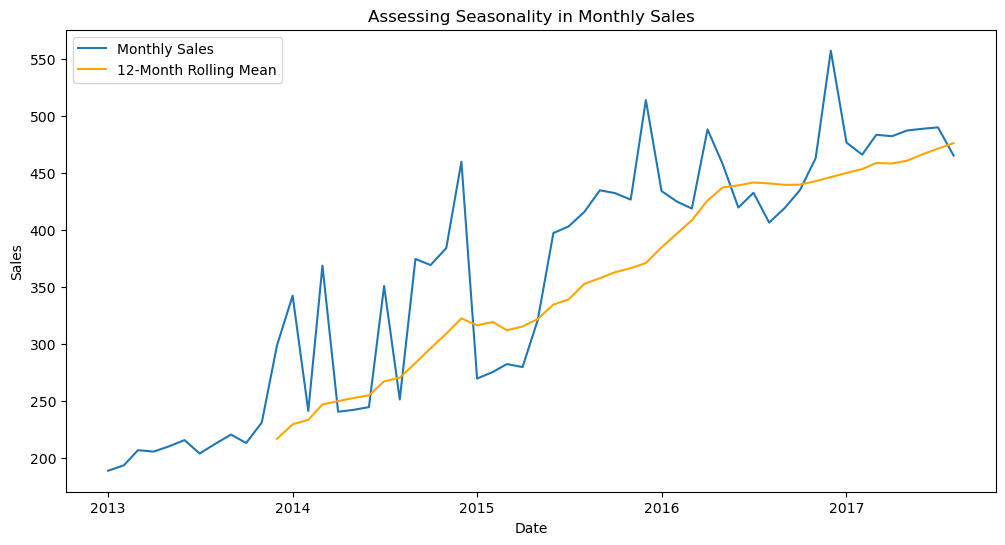

In [60]:
# Plot the monthly sales and the rolling mean to assess seasonality
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.plot(rolling_mean, label=f'{window}-Month Rolling Mean', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Assessing Seasonality in Monthly Sales')
plt.legend()
plt.show()

In [61]:
sales_df = df.copy()

#### Feature Engineering

#### Hypothesis 1 - Seasonal Sales Variations:
Null Hypothesis (H0): There is no significant seasonal variation in sales. Alternative Hypothesis (H1): Sales exhibit significant seasonal patterns, such as increased sales during certain months.

#### Hypothesis 2 - Promotion Effectiveness:
Null Hypothesis (H0): Promotions have no significant impact on sales. Alternative Hypothesis (H1): Sales are significantly higher during promotional periods compared to non-promotional periods.

#### Hypothesis 3 - Store Type Influence:
Null Hypothesis (H0): The type of store has no significant effect on sales. Alternative Hypothesis (H1): Certain store types have significantly higher or lower sales compared to others.

#### Hypothesis 4 - Cluster Performance:
Null Hypothesis (H0): Store clusters have no significant impact on sales performance. Alternative Hypothesis (H1): Specific store clusters exhibit significantly different sales performance.

#### Hypothesis 5 - Product Family Impact:
Null Hypothesis (H0): The choice of product family does not significantly affect sales. Alternative Hypothesis (H1): Certain product families have a significant impact on sales, with higher or lower sales compared to others.

#### Hypothesis 6 - Geographic Variations:
Null Hypothesis (H0): Geographic location (city and state) has no significant effect on sales. Alternative Hypothesis (H1): Sales vary significantly based on the city or state where stores are located.

#### Hypothesis 7 - Time Trend:
Null Hypothesis (H0): There is no significant time trend in sales over the years. Alternative Hypothesis (H1): Sales show a significant increasing or decreasing trend over time.

#### Hypothesis 8 - Impact of On-Promotion Products:
Null Hypothesis (H0): The status of products being on promotion or not has no significant effect on sales. Alternative Hypothesis (H1): Sales of products on promotion are significantly different from those not on promotion.

In [62]:
# Split the data into two groups: sales during promotions and sales without promotions
sales_promo = sales_df[sales_df['onpromotion'] == 1]['sales']
sales_no_promo = sales_df[sales_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare the means of the two groups
t_stat, p_value = stats.ttest_ind(sales_promo, sales_no_promo, equal_var=False)

# Define the significance level (alpha)
alpha = 0.05

# Check the p-value against the significance level to determine significance
if p_value < alpha:
    print("Reject the Null Hypothesis (H0)")
    print("Sales are significantly higher during promotional periods.")
else:
    print("Fail to reject the Null Hypothesis (H0)")
    print("There is no significant difference in sales between promotional and non-promotional periods.")

Reject the Null Hypothesis (H0)
Sales are significantly higher during promotional periods.


In [63]:
# Perform an ANOVA test to compare sales across different store types
store_types = sales_df['type_x'].unique()
store_type_groups = [sales_df[sales_df['type_x'] == store_type]['sales'] for store_type in store_types]
# Perform the ANOVA test
f_stat, p_value = stats.f_oneway(*store_type_groups)

# Define the significance level (alpha)
alpha = 0.05

# Check the p-value against the significance level to determine significance
if p_value < alpha:
    print("Reject the Null Hypothesis (H0)")
    print("There is a significant difference in sales across different store types.")
else:
    print("Fail to reject the Null Hypothesis (H0)")
    print("The type of store does not have a significant effect on sales.")

Reject the Null Hypothesis (H0)
There is a significant difference in sales across different store types.


In [64]:
# Perform an ANOVA test to compare sales across different clusters
clusters = sales_df['cluster'].unique()
cluster_groups = [sales_df[sales_df['cluster'] == cluster]['sales'] for cluster in clusters]

# Perform the ANOVA test
f_stat, p_value = stats.f_oneway(*cluster_groups)

# Define the significance level (alpha)
alpha = 0.05

# Check the p-value against the significance level to determine significance
if p_value < alpha:
    print("Reject the Null Hypothesis (H0)")
    print("There is a significant difference in sales performance across store clusters.")
else:
    print("Fail to reject the Null Hypothesis (H0)")
    print("Store clusters do not have a significant impact on sales performance.")

Reject the Null Hypothesis (H0)
There is a significant difference in sales performance across store clusters.


In [65]:
# Perform an ANOVA test to compare sales across different product families
product_families = sales_df['family'].unique()
family_groups = [sales_df[sales_df['family'] == family]['sales'] for family in product_families]

# Perform the ANOVA test
f_stat, p_value = stats.f_oneway(*family_groups)

# Define the significance level (alpha)
alpha = 0.05

# Check the p-value against the significance level to determine significance
if p_value < alpha:
    print("Reject the Null Hypothesis (H0)")
    print("Certain product families have a significant impact on sales.")
else:
    print("Fail to reject the Null Hypothesis (H0)")
    print("The choice of product family does not significantly affect sales.")

Reject the Null Hypothesis (H0)
Certain product families have a significant impact on sales.


In [66]:
# Perform an ANOVA test to compare sales across different cities or states
cities_states = sales_df['city'] + ', ' + sales_df['state']
city_state_groups = [sales_df[cities_states == city_state]['sales'] for city_state in cities_states.unique()]

# Perform the ANOVA test
f_stat, p_value = stats.f_oneway(*city_state_groups)

# Define the significance level (alpha)
alpha = 0.05

# Check the p-value against the significance level to determine significance
if p_value < alpha:
    print("Reject the Null Hypothesis (H0)")
    print("Sales vary significantly based on geographic location.")
else:
    print("Fail to reject the Null Hypothesis (H0)")
    print("Geographic location does not have a significant effect on sales.")

Reject the Null Hypothesis (H0)
Sales vary significantly based on geographic location.


In [67]:
from scipy.stats import linregress

In [68]:
# Perform linear regression to assess the time trend
slope, intercept, r_value, p_value, std_err = linregress(range(len(yearly_sales)), yearly_sales)

# Define the significance level (alpha)
alpha = 0.05

# Check the p-value against the significance level to determine significance
if p_value < alpha:
    print("Reject the Null Hypothesis (H0)")
    print("Sales show a significant time trend.")
    print(f"Annual Sales Trend (Slope): {slope:.2f}")
else:
    print("Fail to reject the Null Hypothesis (H0)")
    print("There is no significant time trend in sales.")

Fail to reject the Null Hypothesis (H0)
There is no significant time trend in sales.


In [69]:
# Split the data into two groups: sales during promotions and sales without promotions
sales_promo = sales_df[sales_df['onpromotion'] == 1]['sales']
sales_no_promo = sales_df[sales_df['onpromotion'] == 0]['sales']

# Perform a two-sample t-test to compare the means of the two groups
t_stat, p_value = stats.ttest_ind(sales_promo, sales_no_promo, equal_var=False)

# Define the significance level (alpha)
alpha = 0.05

# Check the p-value against the significance level to determine significance
if p_value < alpha:
    print("Reject the Null Hypothesis (H0)")
    print("Sales of products on promotion are significantly different from those not on promotion.")
else:
    print("Fail to reject the Null Hypothesis (H0)")
    print("The status of products being on promotion or not does not have a significant effect on sales.")

Reject the Null Hypothesis (H0)
Sales of products on promotion are significantly different from those not on promotion.


In [70]:
holly_df['date'] = pd.to_datetime(holly_df['date'])

In [71]:
# Create a binary feature indicating whether a day is a holiday or not
sales_df['is_holiday'] = sales_df['date'].isin(holly_df['date']).astype(int)

# Sort the 'holiday_df' by date
holly_df = holly_df.sort_values(by='date')

# Generate features for days until the next holiday and days since the last holiday
sales_df['days_until_next_holiday'] = sales_df['date'].sub(holly_df['date'].shift(-1)).dt.days
sales_df['days_since_last_holiday'] = sales_df['date'].sub(holly_df['date'].shift(1)).dt.days

# Replace NaN values in the new features with appropriate values
sales_df['days_until_next_holiday'].fillna(sales_df['days_until_next_holiday'].max(), inplace=True)
sales_df['days_since_last_holiday'].fillna(sales_df['days_since_last_holiday'].min(), inplace=True)

In [72]:
# Calculate average sales per day for each store
store_sales_avg = sales_df.groupby('store_nbr')['sales'].mean().reset_index()
store_sales_avg.rename(columns={'sales': 'avg_sales_per_day'}, inplace=True)

In [73]:
# Merge the calculated averages back into your main DataFrame
sales_df = sales_df.merge(store_sales_avg, on='store_nbr', how='left')

In [74]:
df

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,...,state,type_y,cluster,dcoilwtico,year,month,day,weekday,day_of_week,weekend
561,561,2013-01-01,25,AUTOMOTIVE,0.000,0,770.0,Holiday,National,Ecuador,...,Santa Elena,D,1,93.14,2013,1,1,1,1,0
562,562,2013-01-01,25,BABY CARE,0.000,0,770.0,Holiday,National,Ecuador,...,Santa Elena,D,1,93.14,2013,1,1,1,1,0
563,563,2013-01-01,25,BEAUTY,2.000,0,770.0,Holiday,National,Ecuador,...,Santa Elena,D,1,93.14,2013,1,1,1,1,0
564,564,2013-01-01,25,BEVERAGES,810.000,0,770.0,Holiday,National,Ecuador,...,Santa Elena,D,1,93.14,2013,1,1,1,1,0
565,565,2013-01-01,25,BOOKS,0.000,0,770.0,Holiday,National,Ecuador,...,Santa Elena,D,1,93.14,2013,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0,Holiday,Local,Riobamba,...,Pichincha,B,6,47.57,2017,8,15,1,1,0
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,Holiday,Local,Riobamba,...,Pichincha,B,6,47.57,2017,8,15,1,1,0
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0,Holiday,Local,Riobamba,...,Pichincha,B,6,47.57,2017,8,15,1,1,0
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,Holiday,Local,Riobamba,...,Pichincha,B,6,47.57,2017,8,15,1,1,0


In [75]:
# Calculate the number of items on promotion for each family on a given day
promotion_features = sales_df.groupby(['date', 'family'])['onpromotion'].sum().reset_index()
promotion_features.rename(columns={'onpromotion': 'family_promotion_count'}, inplace=True)
sales_df = sales_df.merge(promotion_features, on=['date', 'family'], how='left')

In [76]:
oil_sales_data = sales_df[['date', 'sales', 'dcoilwtico']]

In [77]:
 #Calculate correlation between oil prices and sales
correlation = oil_sales_data['sales'].corr(oil_sales_data['dcoilwtico'])

# Print the correlation coefficient
print(f"Correlation between sales and oil prices: {correlation}")

Correlation between sales and oil prices: -0.0754052111371969


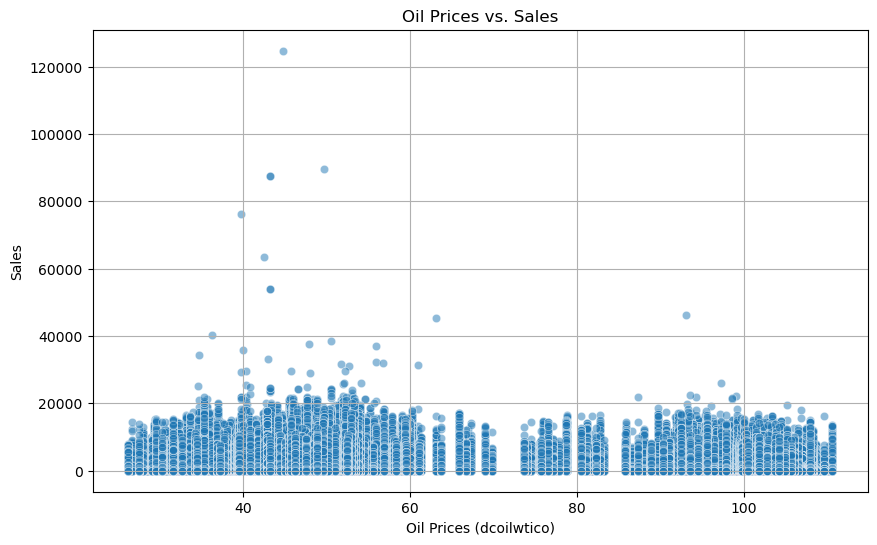

In [78]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=oil_sales_data, x='dcoilwtico', y='sales', alpha=0.5)
plt.title("Oil Prices vs. Sales")
plt.xlabel("Oil Prices (dcoilwtico)")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

#### Model and Predictions

In [79]:
sales_df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,...,month,day,weekday,day_of_week,weekend,is_holiday,days_until_next_holiday,days_since_last_holiday,avg_sales_per_day,family_promotion_count
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,770.0,Holiday,National,Ecuador,...,1,1,1,1,0,1,NaN,NaN,206.05064,0
1,562,2013-01-01,25,BABY CARE,0.0,0,770.0,Holiday,National,Ecuador,...,1,1,1,1,0,1,NaN,NaN,206.05064,0
2,563,2013-01-01,25,BEAUTY,2.0,0,770.0,Holiday,National,Ecuador,...,1,1,1,1,0,1,NaN,NaN,206.05064,0
3,564,2013-01-01,25,BEVERAGES,810.0,0,770.0,Holiday,National,Ecuador,...,1,1,1,1,0,1,NaN,NaN,206.05064,0
4,565,2013-01-01,25,BOOKS,0.0,0,770.0,Holiday,National,Ecuador,...,1,1,1,1,0,1,NaN,NaN,206.05064,0


In [80]:
test_df = pd.read_csv('test.csv')

In [81]:
sales_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'type_x', 'locale', 'locale_name', 'description',
       'transferred', 'city', 'state', 'type_y', 'cluster', 'dcoilwtico',
       'year', 'month', 'day', 'weekday', 'day_of_week', 'weekend',
       'is_holiday', 'days_until_next_holiday', 'days_since_last_holiday',
       'avg_sales_per_day', 'family_promotion_count'],
      dtype='object')

In [82]:
sales_df.sort_values(by='date', inplace=True)

# Create a time series for training with 'date' as the index and 'sales' as the target variable
train_series = sales_df.set_index('date')['sales']

# Display the first few rows of the train_series
print(train_series.head())

date
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
Name: sales, dtype: float64


In [83]:
sales_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'type_x', 'locale', 'locale_name', 'description',
       'transferred', 'city', 'state', 'type_y', 'cluster', 'dcoilwtico',
       'year', 'month', 'day', 'weekday', 'day_of_week', 'weekend',
       'is_holiday', 'days_until_next_holiday', 'days_since_last_holiday',
       'avg_sales_per_day', 'family_promotion_count'],
      dtype='object')

In [84]:
model_df = sales_df[['id','date', 'store_nbr',  'sales', 'onpromotion']].copy()

In [85]:
# Rename columns to match Prophet's expectations
model_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

In [ ]:
# Assuming you have a DataFrame 'train_df' with columns 'ds' (date) and 'y' (target variable)
model_prophet = Prophet()
model_prophet.fit(model_df)

In [ ]:
n_forecast = 30 

In [ ]:
# Create a DataFrame with future dates for forecasting
future = model_prophet.make_future_dataframe(periods=n_forecast)

In [ ]:
# Make forecasts for future dates
forecast_prophet = model_prophet.predict(future)

In [ ]:
test_df.columns

In [ ]:
xgb_df = model_df[['id', 'ds','store_nbr', 'y', 'onpromotion']]

In [ ]:
# Assuming you have a DataFrame 'train_df' with features and 'y' as the target variable
X = xgb_df.drop(columns=['y'])
y = xgb_df['y']

In [ ]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create an XGBoost regressor and set hyperparameters
model_xgboost = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror')

In [ ]:
# Drop the original 'ds' column if no longer needed
model_df.drop(columns=['ds'], inplace=True)

In [ ]:
# Convert 'ds' column to numerical features
#model_df['year'] = model_df['ds'].dt.year
#model_df['month'] = model_df['ds'].dt.month
#model_df['day'] = model_df['ds'].dt.day
#model_df['weekday'] = model_df['ds'].dt.weekday
#model_df['day_of_week'] = model_df['ds'].dt.dayofweek
#model_df['weekend'] = (model_df['ds'].dt.weekday >= 5).astype(int)

# Drop the original 'ds' column if no longer needed
#model_df.drop(columns=['ds'], inplace=True)

In [ ]:
# Assuming you have a DataFrame 'xgb_df' with features and 'y' as the target variable
X = xgb_df.drop(columns=['y', 'ds'])  # Exclude the 'ds' column
y = xgb_df['y']

In [ ]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create an XGBoost regressor and set hyperparameters
model_xgboost = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror')

In [ ]:
# Train the model
model_xgboost.fit(X_train, y_train)

In [ ]:
model_df.columns

In [ ]:
xgb_test = test_df[['store_nbr', 'family', 'onpromotion']]

In [ ]:
# Make predictions on the validation set
predictions_xgboost = model_xgboost.predict(X_valid)

In [ ]:
# Calculate Mean Absolute Error (MAE) as an evaluation metric
mae_xgboost = mean_absolute_error(y_valid, predictions_xgboost)

In [ ]:
# To make forecasts on the test data, use model_xgboost.predict(test_data)
predictions_test_xgboost = model_xgboost.predict(xgb_test)

In [ ]:
# Assuming you have a time series 'train_series' as a pandas Series
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_series.values.reshape(-1, 1))

In [ ]:
# Create sequences and labels for training
sequence_length = 10  # Define the length of your input sequences
X_train, y_train = [], []
for i in range(len(train_data) - sequence_length):
    X_train.append(train_data[i:i+sequence_length])
    y_train.append(train_data[i+sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)


In [ ]:
# Build an LSTM model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
n_forecast = 30
forecast_input = train_data[-sequence_length:].reshape(1, sequence_length, 1)
forecast = model_lstm.predict(forecast_input)

In [ ]:
model_arima = ARIMA(train_series, order=(p, d, q))  
model_arima_fit = model_arima.fit()

In [ ]:
n_forecast = 30
forecast_arima = model_arima_fit.forecast(steps=n_forecast)